# 데이터세트 준비하기

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 기존 폴더 경로
source_path = '/content/drive/MyDrive/Aivle_빅프/china_input_img'
# ImageFolder 형식으로 저장할 경로
destination_path = "/content/drive/MyDrive/Aivle_빅프/Infant_Dataset_all_label"
splits = ["train", "val", "test"]

# 클래스 폴더 정의 (awake, diaper, hug, hungry, sleepy, uncomfortable)
classes = os.listdir(source_path)

# 새로운 폴더 구조 생성
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(destination_path, split, class_name), exist_ok=True)

# 데이터셋 분할 및 복사
for class_name in classes:
    class_folder = os.path.join(source_path, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith((".png", ".jpg", ".jpeg", ".bmp"))]

    # Train(70%), Val(20%), Test(10%) 분할
    train_imgs, test_imgs = train_test_split(images, test_size=0.1, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)

    # Copy images to train folder
    for img in train_imgs:
        shutil.copy(
            os.path.join(class_folder, img),
            os.path.join(destination_path, "train", class_name, img)
        )

    # Copy images to val folder
    for img in val_imgs:
        shutil.copy(
            os.path.join(class_folder, img),
            os.path.join(destination_path, "val", class_name, img)
        )

    # Copy images to test folder
    for img in test_imgs:
        shutil.copy(
            os.path.join(class_folder, img),
            os.path.join(destination_path, "test", class_name, img)
        )

print("Data has been successfully split into train, val, and test folders!")

Data has been successfully split into train, val, and test folders!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

In [17]:
# 경로 설정
data_path = "/content/drive/MyDrive/Aivle_빅프/Infant_Dataset_all_label"

# 1. 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.Resize((108, 120)),  # 모든 이미지를 224x224로 크기 조정
    transforms.ToTensor(),         # Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 2. 데이터셋 로드
train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_path}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_path}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 클래스 확인
print(f"Classes: {train_dataset.classes}")
print(f"Class to Index Mapping: {train_dataset.class_to_idx}")

Classes: ['awake', 'diaper', 'hug', 'hungry', 'sleepy', 'uncomfortable']
Class to Index Mapping: {'awake': 0, 'diaper': 1, 'hug': 2, 'hungry': 3, 'sleepy': 4, 'uncomfortable': 5}


In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SE(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SE, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Global pooling for 4D input
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Global pooling
        batch_size, channels, _, _ = x.size()  # 4D tensor: (B, C, H, W
        out = self.global_pooling(x).view(batch_size, channels)  # (B, C, 1, 1) -> (B, C)

        # Adjust fc1's input features
        out = self.fc1(out)  # (B, C) -> (B, C // reduction_ratio)
        out = self.relu(out)
        out = self.fc2(out)  # (B, C // reduction_ratio) -> (B, C)
        out = self.sigmoid(out).view(batch_size, channels, 1, 1)  # Reshape to (B, C, 1, 1)

        return x * out  # Scale input by SE output



class SE_ResNet(nn.Module):
    def __init__(self, input_channel, num_classes, reduction_ratio=16):
        super(SE_ResNet, self).__init__()

        # Initial Conv Block with Conv2d
        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p = 0.5)

        # Multi-scale Convolutions with Conv2d
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv55 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2, bias=False)
        self.conv77 = nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=3, bias=False)

        # SE Block with Global Average Pooling (adjusted for 2D input)
        self.se_block = SE(192, reduction_ratio=reduction_ratio)

        # 1x1 Convolution for Channel Matching
        self.residual_conv = nn.Conv2d(64, 192, kernel_size=1, stride=1, padding=0, bias=False)

        # Fully Connected Layer 정의
        self.fc = nn.Linear(192, num_classes)

        # Dropout
        self.final_dropout = nn.Dropout(p = 0.5)

    def SE_Residual_Block(self, x):
        residual = self.residual_conv(x)  # Save the input for residual connection

        # Multi-scale Convolutions
        out_3 = self.conv33(x)
        out_5 = self.conv55(x)
        out_7 = self.conv77(x)

        # Concatenate along the channel dimension
        out = torch.cat([out_3, out_5, out_7], dim=1)

        # Apply SE block
        out_se = self.se_block(out)  # Scale factors (B, C, 1, 1)

        # Scale `out` with `out_se`
        out_scaled = out * out_se  # Element-wise scaling

        # Add residual connection
        out_scaled += residual  # Ensure `residual` matches the shape of `out_scaled`

        # Apply ReLU activation
        out = self.relu(out_scaled)

        # Apply dropout
        out = self.final_dropout(out)

        return out

    def forward(self, x):
        # Initial Conv Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # SE-Residual Block
        x = self.SE_Residual_Block(x)

        # # Global Average Pooling (convert 4D -> 2D for fc layer)
        # x = torch.mean(x, dim=(2, 3))  # Average over height and width

        # # Fully Connected Layer
        # print(f'before x :{x.shape}')
        # # x = self.fc(x)
        # print(f'after x :{x.shape}')

        return x


class SpatialPyramidPooling(nn.Module):
    def __init__(self, levels=[1, 2, 4]):
        super(SpatialPyramidPooling, self).__init__()
        self.levels = levels

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        features = []

        for level in self.levels:
            kernel_size = (height // level, width // level)
            stride = kernel_size
            pooling = nn.AdaptiveMaxPool2d((level, level))
            pooled = pooling(x)
            features.append(pooled.view(batch_size, -1))  # Flatten each level

        return torch.cat(features, dim=1)  # Concatenate all levels


class SE_ResNet_Transformer(nn.Module):
    def __init__(self, input_channel, num_classes):
        super(SE_ResNet_Transformer, self).__init__()
        self.feature_extractor = SE_ResNet(input_channel=3, num_classes = num_classes)
        self.spp = SpatialPyramidPooling(levels=[1, 2, 4])  # SPP 구현
        self.transformer1 = nn.Transformer(d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=32)
        self.transformer2 = nn.Transformer(d_model=64, nhead=8, num_encoder_layers=2, dim_feedforward=64)
        self.transformer3 = nn.Transformer(d_model=64, nhead=16, num_encoder_layers=2, dim_feedforward=128)
        self.fc2 = nn.Linear(64, 6)
        self.softmax = nn.Softmax(dim=1)
        self.conv1x1 = nn.Conv2d(4032, 64, kernel_size=1, stride=1, bias=False)

    def forward(self, x):
        # Feature Extraction
        x = self.feature_extractor(x)
        # print(f'feature_extractor : {x.shape}')

        # SPP
        x = self.spp(x)
        # print(f'after spp : {x.shape}')  # (batch_size, 4032)

        # Reshape SPP Output
        x = x.view(x.size(0), 4032, 1, 1)  # Reshape to 4D for Conv2D
        x = self.conv1x1(x)  # Apply 1x1 Conv2D to reduce channels
        # print(f'after 1x1 Conv2D : {x.shape}')  # (batch_size, d_model, 1, 1)
        x = x.view(x.size(0), -1, 64)  # Reshape for Transformer: (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)

        # Transformer Layers
        x = self.transformer1(x, x)
        x = self.transformer2(x, x)
        x = self.transformer3(x, x)

        # Average Pooling
        x = x.mean(dim=0)  # Global Average Pooling along the sequence dimension

        # Fully Connected Layer + Softmax
        x = self.fc2(x)
        out = self.softmax(x)
        return out


In [115]:
# 4. 학습 루프
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device="cuda"):
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training 단계
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation 단계
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [116]:
# 모델 초기화
num_classes = len(train_dataset.classes)
model = SE_ResNet_Transformer(input_channel = 3, num_classes=num_classes)

# 3. 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 모델 학습
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cuda"
)

# x축에 해당하는 epoch 정보 생성
epochs = list(range(1, len(train_losses) + 1))

Epoch 1/10
------------------------------


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]

Train Loss: 1.7929 Acc: 0.1874


Val Loss: 1.7864 Acc: 0.1980
Epoch 2/10
------------------------------


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]

Train Loss: 1.7930 Acc: 0.1804


Val Loss: 1.7875 Acc: 0.1980
Epoch 3/10
------------------------------


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]

Train Loss: 1.7883 Acc: 0.1966


Val Loss: 1.7880 Acc: 0.1980
Epoch 4/10
------------------------------


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]

Train Loss: 1.7877 Acc: 0.1887


Val Loss: 1.7864 Acc: 0.1980
Epoch 5/10
------------------------------


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]

Train Loss: 1.7882 Acc: 0.1896


Val Loss: 1.7869 Acc: 0.1980
Epoch 6/10
------------------------------


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]

Train Loss: 1.7887 Acc: 0.1915


Val Loss: 1.7861 Acc: 0.1980
Epoch 7/10
------------------------------


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]

Train Loss: 1.7880 Acc: 0.1953


Val Loss: 1.7866 Acc: 0.1980
Epoch 8/10
------------------------------


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]

Train Loss: 1.7882 Acc: 0.1979


Val Loss: 1.7859 Acc: 0.1980
Epoch 9/10
------------------------------


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]

Train Loss: 1.7880 Acc: 0.1947


Val Loss: 1.7860 Acc: 0.1980
Epoch 10/10
------------------------------


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]

Train Loss: 1.7886 Acc: 0.1851


Val Loss: 1.7860 Acc: 0.1980


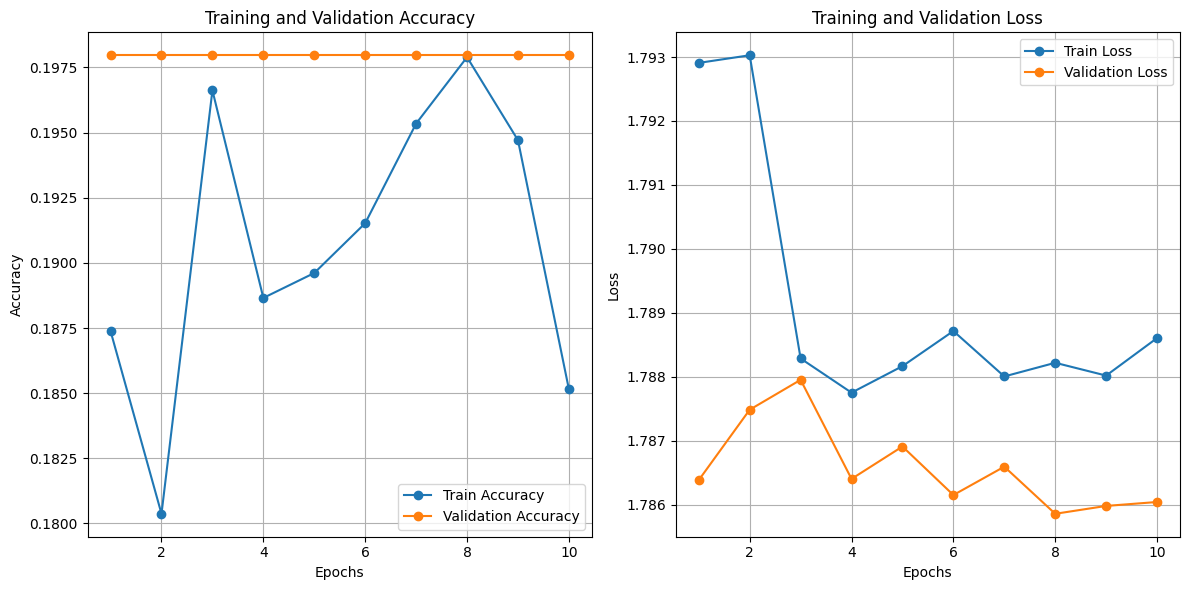

In [117]:
 import matplotlib.pyplot as plt

# Plotting Accuracy and Loss in one figure with subplots
plt.figure(figsize=(12,6))

# Subplot for Accuracy
plt.subplot(1, 2, 1)  # (rows, cols, index)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Subplot for Loss
plt.subplot(1,2, 2)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Show the combined plot
plt.tight_layout()  # Adjusts spacing between subplots to prevent overlap
plt.show()
